In [0]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    #!git clone https://github.com/mjwock/DeepFLaSH_Pytorch.git /content/drive/My\ Drive/DeepFLaSH_Pytorch/FastAI/
    %cd /content/drive/My\ Drive/DeepFLaSH_Pytorch/FastAI2
    #!git pull
except:
    pass

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

!pip install elasticdeform

import numpy as np
import pandas as pd

from fastai.vision import *
from torch import nn
#import torch.nn.functional as F
#import torchvision
from sklearn.model_selection import StratifiedKFold

#from scipy.ndimage.interpolation import map_coordinates
#from scipy.ndimage.filters import gaussian_filter

from deepflash import preproc, unetadaption, utility
from deepflash.fastai_extension import *

#from skimage import io
#from tqdm import tqdm

#import random
import os
from pathlib import Path
import scipy.io
import matplotlib.pyplot as plt

## Settings

General Params

In [0]:
DIR = '/content/drive/My Drive/DeepFLaSH_Pytorch/FastAI2/data'


MASK_TYPE = 'cFOS'   # 'cFOS','Parv','NeuN'
CODER = ['gt']  # 'gt','cora','corinna','dennis','manju','manual','rohini','unet_cv10','unet_cv36'
COLOR = 'red'   # 'red','green'

TILE_SHAPE = (540,540)    # desired input
PADDING = (184,184)       # 540-356
EL_SIZE = [635.9, 635.9]

SEED = 42

In [0]:
# ONLY CHANGE FOR DIFFERENT FOLDER STRUCTURE
IMG_PATH = f'{DIR}/images/{COLOR}'
MASK_PATH = f'{DIR}/temp_data/labels/'
WEIGHT_PATH = f'{DIR}/temp_data/weights/'

# DON'T CHANGE
MASK_SHAPE = tuple(np.subtract(TILE_SHAPE,PADDING))

Training Params

In [0]:
BATCH_NORM = False
BATCH_SIZE = 2
EPOCHS = 100
N_SPLITS = 10

Network Params

In [0]:
IN_CHANNELS = 1
OUT_CHANNELS = 2  #number of classes
DEPTH = 5

# Custom Net Overview

In [0]:
from torchsummary import summary
#GPU Hardware Acceleration needed (cuda)

net = unetadaption.UNet(in_channels=IN_CHANNELS,n_classes=OUT_CHANNELS,depth=DEPTH).cuda()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = net.to(device)

summary(model, input_size=(IN_CHANNELS, TILE_SHAPE[0], TILE_SHAPE[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 538, 538]             640
              ReLU-2         [-1, 64, 538, 538]               0
            Conv2d-3         [-1, 64, 536, 536]          36,928
              ReLU-4         [-1, 64, 536, 536]               0
     UNetConvBlock-5         [-1, 64, 536, 536]               0
            Conv2d-6        [-1, 128, 266, 266]          73,856
              ReLU-7        [-1, 128, 266, 266]               0
            Conv2d-8        [-1, 128, 264, 264]         147,584
              ReLU-9        [-1, 128, 264, 264]               0
    UNetConvBlock-10        [-1, 128, 264, 264]               0
           Conv2d-11        [-1, 256, 130, 130]         295,168
             ReLU-12        [-1, 256, 130, 130]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1

## Load Data

Retrieve images from folder

In [0]:
filenames = os.listdir(IMG_PATH)

img_ids = [os.path.splitext(files)[0] for files in filenames] #get list with img_ids
img_ext = os.path.splitext(filenames[0])[1] #get image extension

In [0]:
images = [img_name for img_name in [f'{s}{img_ext}' for s in img_ids]]
img_df = pd.DataFrame([Path(image) for image in images])

Function to map from image path to mask and weight paths

In [0]:
### TODO: fix for multiple coder: CODER[i]
regDigits = "\d{4}"
get_labels = lambda x: Path(f'{MASK_PATH}/{re.findall(regDigits,Path(x).stem)[0]}.tif')
get_weights = lambda x: Path(f'{WEIGHT_PATH}/{re.findall(regDigits,Path(x).stem)[0]}.tif')

Show example image, labels and weights

/usr/local/lib/python3.6/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_packbits'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/usr/local/lib/python3.6/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_lzw'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/usr/local/lib/python3.6/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'unpack_ints'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/usr/local/lib/python3.6/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'reverse_bitorder'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))


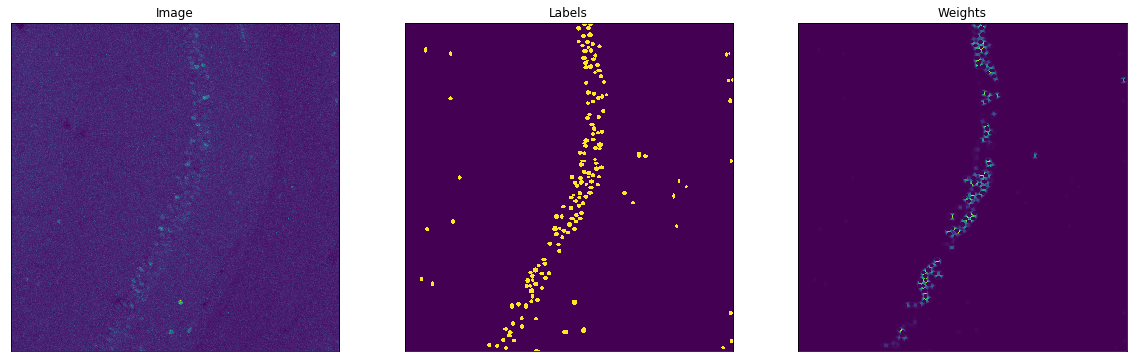

In [0]:
utility.show_example_data_batch(IMG_PATH,img_df,get_labels,get_weights, n=1)

# Create Databunch object for further training

Custom 'get_transforms()' function for selected augmentations

In [0]:
tfms = get_custom_transforms()
#tfms = None                      ####### Pixelwerte für Labels verändern sich auch bei tfms = None

Create databunch object

In [0]:
src = (CustomSegmentationItemList.from_df(img_df,IMG_PATH, convert_mode='L')
      # import from df in greyscale ('L')
      .split_by_rand_pct(valid_pct=(1/N_SPLITS))
      # 1/10 train/validation split
      .label_from_funcs(get_labels, get_weights, target_size=MASK_SHAPE, classes = array(['background','cell']))
      # segmentation labels and weights
)

data = (src.transform(tfms=tfms, tfm_y=True, resize_method=ResizeMethod.CROP,size=TILE_SHAPE)
        # apply data augmentation
        .databunch(bs=BATCH_SIZE)
        # set batchsize
)

Masks will be cropped to (356, 356). Choose 'None' to keep initial size.
Masks will be cropped to (356, 356). Choose 'None' to keep initial size.


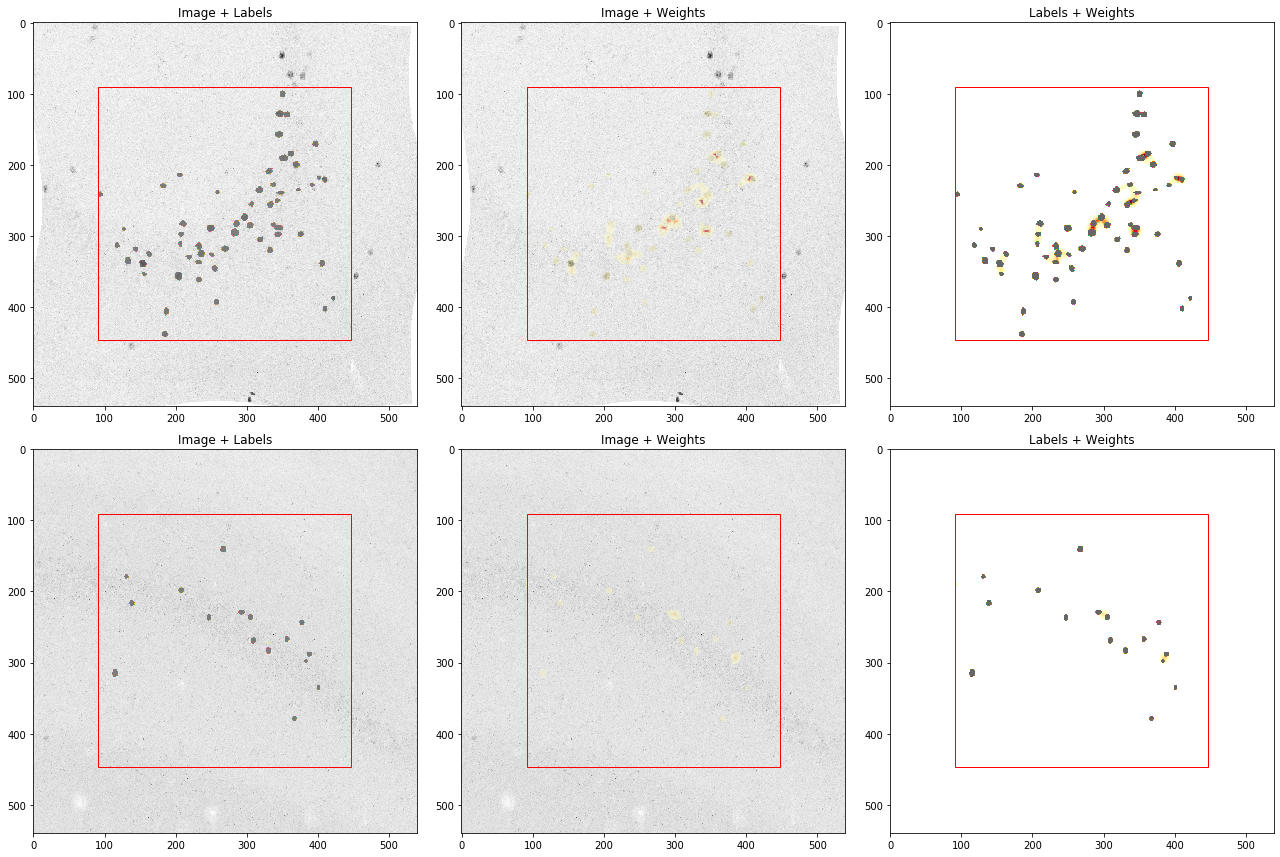

In [0]:
data.show_batch()

**Train**

Metrics

In [0]:
# loss_wrapper let's you use any metric for this architecture (get's rid of the weights)
# if 'swap_preds = True' inputs are swapped (useful for sklearn.metrics)

IoU = loss_wrapper(metric=dice, iou=True)
f1 = loss_wrapper(metric=fbeta, beta=1)

Learner

In [0]:
learn = Learner(data, 
                net,
                model_dir = DIR,
                opt_func = torch.optim.Adam,
                metrics = [IoU,f1],
                loss_func = WeightedCrossEntropyLoss(axis=1, reduction_mode='sum'),
                wd=0.05)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


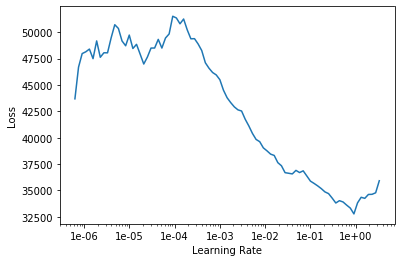

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(20,max_lr=5e-3)

epoch,train_loss,valid_loss,IoU,f1,time
0,35933.480469,17982.193359,0.000000,0.033502,00:13
1,31287.906250,17982.193359,0.000000,0.033502,00:13
2,29264.123047,17982.193359,0.000000,0.033502,00:14
3,27871.458984,17982.193359,0.000000,0.033502,00:14
4,27671.085938,17982.193359,0.000000,0.033502,00:14
5,27179.875000,17982.193359,0.000000,0.033502,00:14
6,27214.824219,17982.193359,0.000000,0.033502,00:14
7,27189.195312,17982.193359,0.000000,0.033502,00:14
8,27319.146484,17982.193359,0.000000,0.033502,00:12
9,27317.052734,17982.193359,0.000000,0.033502,00:14


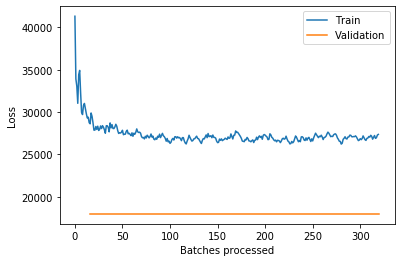

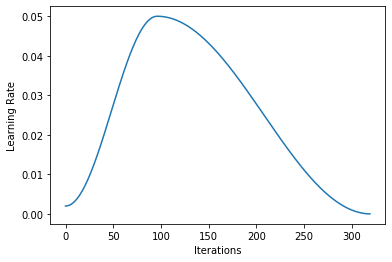

In [0]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()

In [0]:
#skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=1)